### PCA and Logistic Regression Classifier

In [1]:
from Tumor_Classifier_Utils import *

In [2]:
data_train = scio.loadmat('Data/tumor_train_data.mat')
data_val = scio.loadmat('Data/tumor_val_data.mat')
data_test = scio.loadmat('Data/tumor_test_data.mat')

N = 64 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

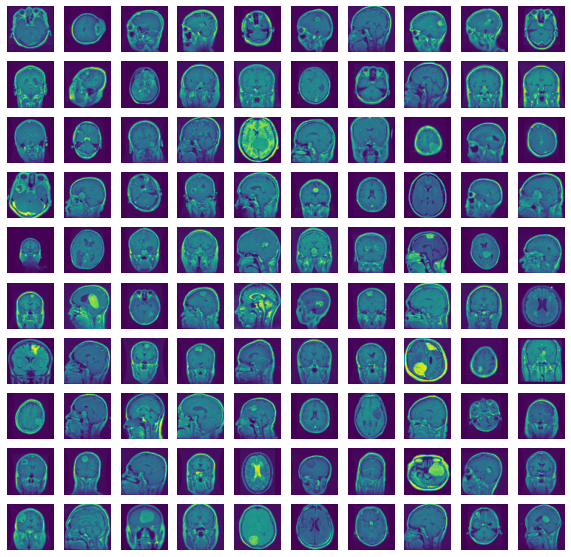

In [3]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

In [4]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

print(train.shape)
print(val.shape)
print(test.shape)

(1958, 64, 64, 1)
(654, 64, 64, 1)
(654, 64, 64, 1)


## Formatting for PCA

In [5]:
train_PCA = np.reshape(train[:,:,:,:], (1958, -1))
val_PCA = np.reshape(val[:,:,:,:], (654, -1))
test_PCA = np.reshape(test[:,:,:,:], (654, -1))

print(train_PCA.shape)
print(val_PCA.shape)
print(test_PCA.shape)

(1958, 4096)
(654, 4096)
(654, 4096)


## PCA

In [6]:
pca = decomposition.PCA()
pca.fit(train_PCA)

PCA()

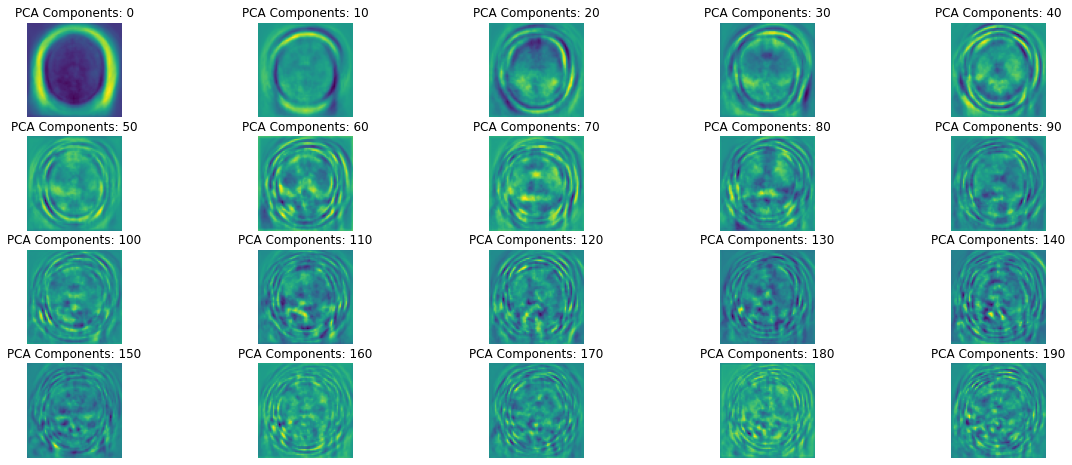

In [7]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)
    pc = np.reshape(pca.components_[i*10,:], (64, 64)) 
    ax.imshow(pc)
    ax.set_title("PCA Components: " + str(i*10))
    plt.axis('off')

In [8]:
transformed_train = pca.transform(train_PCA)
transformed_val = pca.transform(val_PCA)
transformed_test = pca.transform(test_PCA)

In [9]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
top90 = np.where(cumulative_sum > 0.90)[0][0]
top95 = np.where(cumulative_sum > 0.95)[0][0]
top99 = np.where(cumulative_sum > 0.99)[0][0]

top90: 270, top95: 454, top99: 938


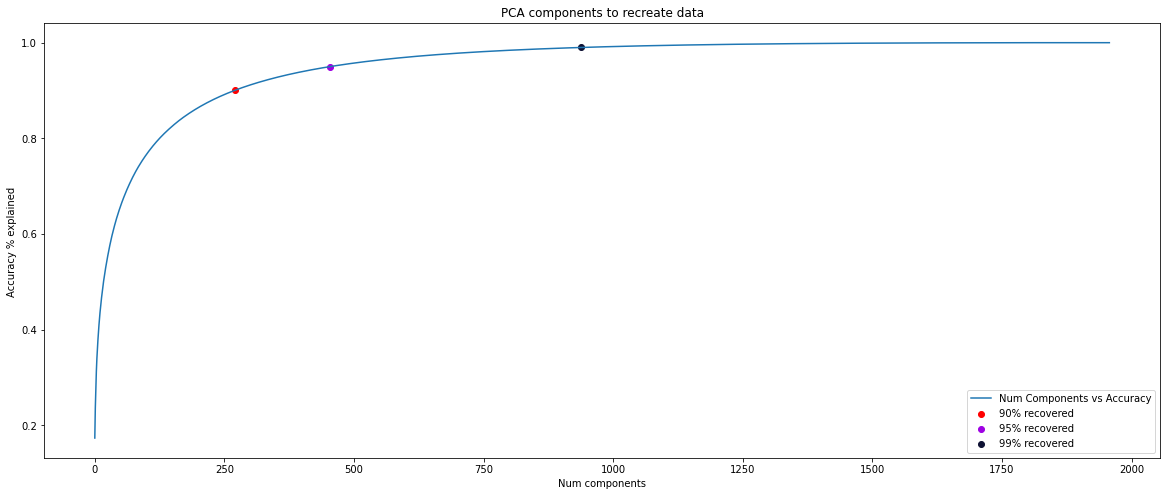

In [10]:
plot_cumulative_sum(cumulative_sum, top90, top95, top99)

(1958, 1958)
(1958, 4096)


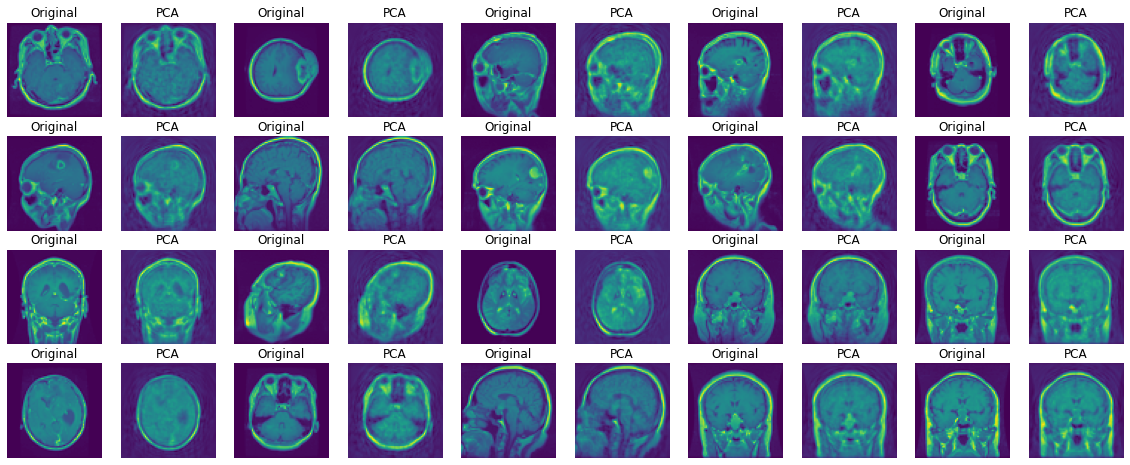

In [11]:
transformed_train_95 = transformed_train
transformed_train_95[:,top95+1:] = 0
print(transformed_train_95.shape)

transform_top95_generate = pca.inverse_transform(transformed_train_95)
print(transform_top95_generate.shape)

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, 2*i + 1)
    ax.imshow(np.reshape(train_PCA[i,:], (64,64)))
    ax.set_title('Original')
    ax.axis('off')
    ax = fig.add_subplot(4, 10, 2*i + 2)
    pc = np.reshape(transform_top95_generate[i,:], (64, 64)) 
    ax.imshow(pc)
    ax.set_title('PCA')
    ax.axis('off')

In [12]:
# choose to use 95% recreation
transformed_train_95 = transformed_train[:, 0:top95]
transformed_val_95 = transformed_val[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

print(transformed_train_95.shape)
print(train_y.shape)

(1958, 454)
(1958, 1)


## Logistic Regression

In [26]:
def search_hyperparams(model, params, X_train, Y_train, X_validate, Y_validate):
    # Create list of all possible combinations
    param_list = list(ParameterGrid(params))
    
    # Initialising 
    best_result = 0.00;
    best_params = param_list[0];
    worst_result = 1.00;
    worst_params = param_list[0];
    # looping through all parameters in parameter list
    for params in param_list:
        # creating model with set parameters
        model = model.set_params(**params)
        # training the model
        model.fit(X_train, Y_train)
        # retrieving model score
        result = model.score(X_validate, Y_validate)
        # checking if model score is better, then allocating best parameters
        if result > best_result:
            best_result = result
            best_params = params
        if result < worst_result:
            worst_result = result
            worst_params = params

    
    # Return the best
    print(best_params)
    print("Validation Accuracy " + str(best_result))
    print(worst_params)
    print("Validation Accuracy " + str(worst_result))
    return best_params

In [27]:
param_grid = {'penalty': ["l2"], 'C': list(range(1, 10)), 'fit_intercept': [True, False], 'class_weight': ["balanced"], 'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

# Find Optimal Hyperparameters and then create model
model = LogisticRegression()
best_params = search_hyperparams(model, param_grid, transformed_train_95, train_y, transformed_val_95, val_y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_

{'C': 4, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
Validation Accuracy 0.7752293577981652
{'C': 5, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.691131498470948


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
model_opt = SVC().set_params(**best_params)
model_opt.fit(transformed_train_95, train_y)

In [29]:
model.fit(transformed_train_95, train_y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=9, class_weight='balanced', fit_intercept=False,
                   solver='saga')

In [28]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    #conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    #conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67        98
           1       0.69      0.74      0.71       192
           2       0.68      0.52      0.59       185
           3       0.88      0.93      0.91       179

    accuracy                           0.73       654
   macro avg       0.72      0.73      0.72       654
weighted avg       0.73      0.73      0.72       654



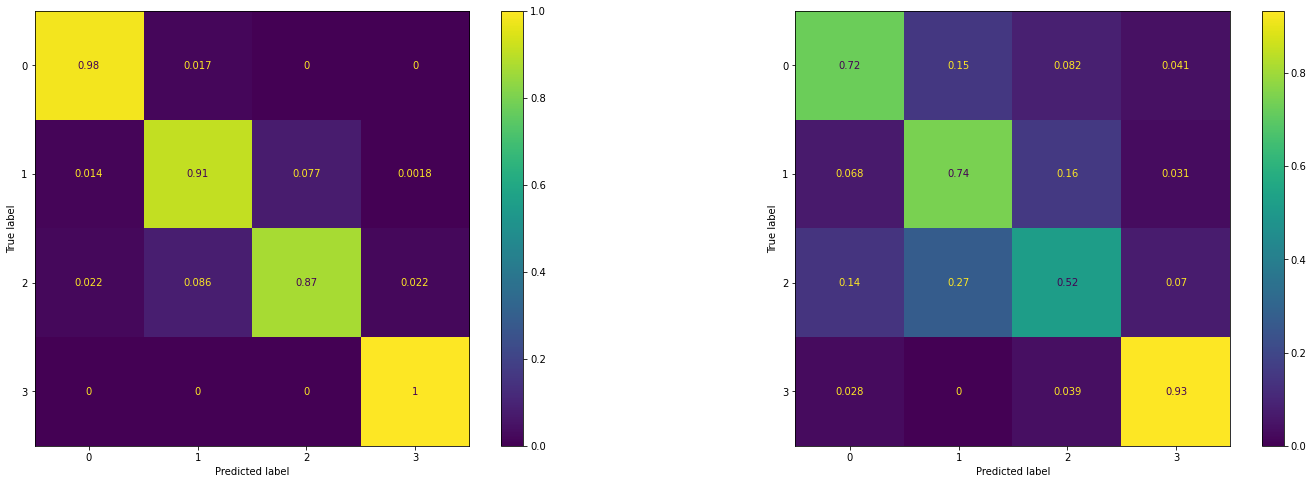

In [30]:
eval_model(model, transformed_train_95, train_y, transformed_test_95, test_y)